In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/데이콘/제주도 교통량 예측

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/데이콘/제주도 교통량 예측


In [5]:
# 파이썬 버전 확인
import sys
print(sys.version)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


In [6]:
# 필요 라이브러리 import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

### Custom Color 적용하기

### 데이터 불러오기

In [7]:
# 각 데이터 불러오기
info = pd.read_csv("./data/data_info.csv")
train_data = pd.read_parquet("./train.parquet")
test_data = pd.read_parquet("./test.parquet")

weather1 = pd.read_csv("./data/2021 제주도 기상 데이터.csv",encoding='cp949')
weather2 = pd.read_csv("./data/2022 제주도 기상 데이터.csv",encoding='cp949')

In [8]:
# 일별 기온, 강수량, 풍속, 적설량, 전운량, 안개 유무 생성
def pp_weather(df):
  df = df.fillna(0)
  df = df.groupby("일시").mean()
  df['강수유무'] = df['일강수량(mm)'].apply(lambda x: 1 if x > 0 else 0)
  df['적설유무'] = df['일 최심신적설(cm)'].apply(lambda x: 1 if x > 0 else 0)
  df = df.drop(['지점','일강수량(mm)','안개 계속시간(hr)','일 최심신적설(cm)'],axis=1)
  df['base_date'] = df.index
  df = df.rename(columns = {'평균기온(°C)' : '평균기온', '평균 풍속(m/s)' : '평균풍속', '평균 전운량(1/10)' : '평균전운량'})
  return df

In [9]:
w1 = pp_weather(weather1)
w2 = pp_weather(weather2)
weather = pd.concat([w1,w2],ignore_index=True)

In [10]:
def preprocessing(df):
  df['base_date'] = df['base_date'].map(lambda x : str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:])
  df['start_end_equal'] = df['start_node_name'] == df['end_node_name']
  df = df.astype({'base_date' : 'object'})
  total_df = pd.merge(df,weather,how='left',on='base_date')
  return total_df

train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [11]:
from sklearn.preprocessing import LabelEncoder
def encoding(df):
  str_col = ['day_of_week','start_turn_restricted','end_turn_restricted','road_name','start_end_equal']
  for i in str_col:
      le = LabelEncoder()
      le=le.fit(train_data[[i]])
      train_data[i]=le.transform(train_data[i])
      
      for label in np.unique(test_data[i]):
          if label not in le.classes_: 
              le.classes_ = np.append(le.classes_, label)
      test_data[i]=le.transform(test_data[i])
  return df

In [12]:
train_set = encoding(train_data)
test_set = encoding(test_data)
train_set.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_latitude,end_longitude,end_turn_restricted,target,start_end_equal,평균기온,평균풍속,평균전운량,강수유무,적설유무
0,TRAIN_0000000,2022-06-23,1,17,1,106,46,0,0,60.0,...,33.427749,126.662335,0,52.0,1,25.200,4.950,7.875,1,0
1,TRAIN_0000001,2022-07-28,1,21,2,103,34,0,0,60.0,...,33.504811,126.526240,0,30.0,0,28.875,3.150,5.025,1,0
2,TRAIN_0000002,2021-10-10,4,7,2,103,36,0,0,80.0,...,33.280072,126.362147,0,61.0,0,25.525,2.325,6.350,1,0
3,TRAIN_0000003,2022-03-11,0,13,2,107,57,0,0,50.0,...,33.245565,126.566228,0,20.0,0,16.175,2.900,7.150,0,0
4,TRAIN_0000004,2021-10-05,6,8,2,103,35,0,0,80.0,...,33.462677,126.330152,0,38.0,0,25.150,2.150,3.250,0,0


Light mode palette
Dark mode palette


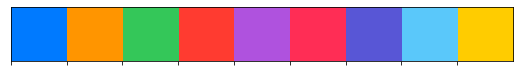

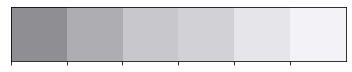

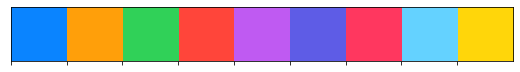

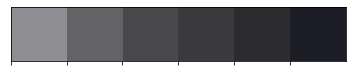

In [13]:
# 그래프 출력 옵션 설정
# 한글 폰트 적용
plt.rc('font', family='NanumBarunGothic')

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# custom 색상 적용(apple color)
from cycler import cycler

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]

light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

# apple에서는 light 버전, dar 버전이 있다.
print('Light mode palette')
sns.palplot(light_palette)
sns.palplot(gray_light_palette)

print('Dark mode palette')
sns.palplot(dark_palette)
sns.palplot(gray_dark_palette)

# dark mode 적용
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)

# 전체적인 배경색 수정
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2] # 배경 색
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2] # 테두리 색
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

# 사용되는 텍스트 색상 흰색으로 수정
white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

# 해상도 조정
mpl.rcParams['figure.dpi'] = 100

# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False


In [14]:
# 범주형 데이터 시각화
def obj_plot(column_name):
    if len(train_data[column_name].unique()) > 20:
        print(len(train_data[column_name].unique()))
    else:
        print(train_data[column_name].value_counts())
    
    
    fig, ax = plt.subplots(1,2,figsize=(12,7))
    sns.countplot(x=column_name,data=train_data,ax=ax[0])
    sns.kdeplot(x='target', data=train_data, ax=ax[1],fill=True,hue=column_name, 
            hue_order=sorted(train_data[column_name].unique()))
						#,multiple="layer"))
    plt.show()


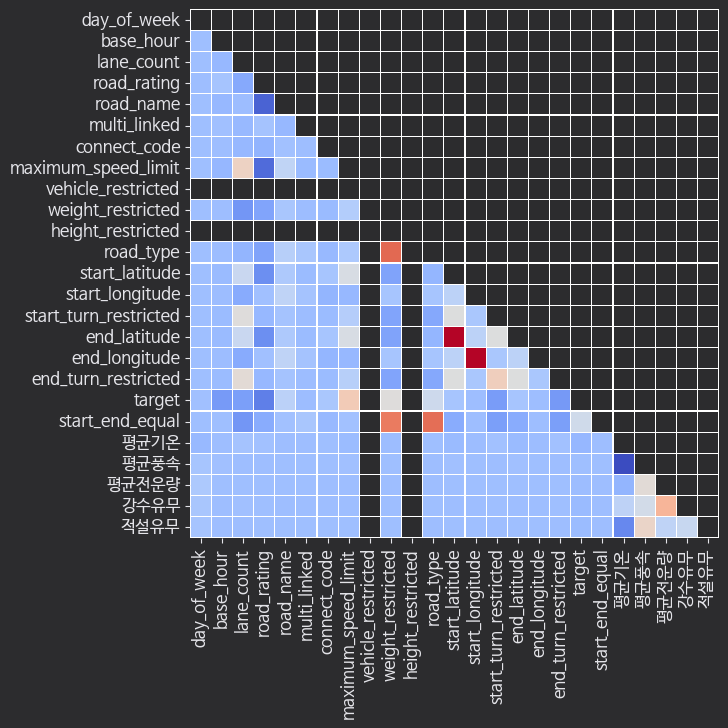

In [ ]:
# 변수 간 상관관계 확인
plt.figure(figsize=(15,7))
mask = np.zeros_like(train_set.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_set.corr(), cmap='coolwarm',linewidth=0.1,square=True,cbar=False,mask=mask)

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_set, test_size=0.2,random_state=42)
print(train.shape)
print(valid.shape)
print("\n")

y_train = train['target']
y_valid = valid['target']
X_train = train.drop(['id','base_date' ,'road_name','target', 'start_node_name', 'height_restricted','end_node_name','vehicle_restricted','multi_linked','connect_code',"day_of_week",'평균기온','평균풍속','평균전운량'], axis=1)
X_valid = valid.drop(['id','base_date' ,'road_name','target', 'start_node_name', 'height_restricted','end_node_name','vehicle_restricted','multi_linked','connect_code',"day_of_week",'평균기온','평균풍속','평균전운량'], axis=1)
test = test_set.drop(['id','base_date', 'road_name','start_node_name', 'end_node_name','height_restricted','vehicle_restricted','multi_linked','connect_code',"day_of_week",'평균기온','평균풍속','평균전운량'], axis=1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(test.shape)

(3760973, 29)
(940244, 29)


(3760973, 15)
(3760973,)
(940244, 15)
(940244,)
(291241, 15)


In [ ]:
# 랜덤포레스트
import time
from sklearn.ensemble import RandomForestRegressor

start_time = time.time()
rf = RandomForestRegressor(random_state=42).fit(X_train,y_train)
print(start_time - time.time())
y_pred = rf.predict(train)

In [ ]:
rf_pred = rf.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_absolute_error
rf_mae = mean_absolute_error(y_valid,rf_pred)
rf_mae

3.579146203638189

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train,y_train)
lr_pred = LR.predict(X_valid)
lr_mae = mean_absolute_error(y_valid,LR_pred)
lr_mae

10.241353142080776

In [ ]:
from sklearn.svm import LinearSVR
svr = LinearSVR(random_state=42).fit(X_train,y_train)
svr_pred = svr.predict(X_valid)
svr_mae = mean_absolute_error(y_valid,svr_pred)
svr_mae

11.360216064072434

In [ ]:
import xgboost
xgb = xgboost.XGBRegressor(tree_method='gpu_hist',random_state=42).fit(X_train,y_train)
xgb_pred = xgb.predict(X_valid)
xgb_mae = mean_absolute_error(y_valid,_pred)
xgb_mae

[10:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


3.579146203638189

In [ ]:
xgb_mae = mean_absolute_error(y_valid,xgb_pred)
xgb_mae

6.56830829826123

In [ ]:
from catboost import CatBoostRegressor, Pool
cb = CatBoostRegressor(random_seed=42,task_type="GPU").fit(X_train,y_train)
cb_pred = cb.predict(X_valid)
cb_mae = mean_absolute_error(y_valid,cb_pred)
cb_mae

Learning rate set to 0.118762
0:	learn: 14.9178155	total: 48.2ms	remaining: 48.1s
1:	learn: 14.0603293	total: 97.3ms	remaining: 48.6s
2:	learn: 13.3524399	total: 141ms	remaining: 47s
3:	learn: 12.7616193	total: 184ms	remaining: 45.9s
4:	learn: 12.2773012	total: 244ms	remaining: 48.5s
5:	learn: 11.8813011	total: 288ms	remaining: 47.6s
6:	learn: 11.5147825	total: 326ms	remaining: 46.2s
7:	learn: 11.2394203	total: 358ms	remaining: 44.3s
8:	learn: 10.9509159	total: 390ms	remaining: 42.9s
9:	learn: 10.7142452	total: 431ms	remaining: 42.7s
10:	learn: 10.5279716	total: 463ms	remaining: 41.6s
11:	learn: 10.3497070	total: 500ms	remaining: 41.1s
12:	learn: 10.1652721	total: 530ms	remaining: 40.3s
13:	learn: 10.0204688	total: 561ms	remaining: 39.5s
14:	learn: 9.9032408	total: 608ms	remaining: 39.9s
15:	learn: 9.7786304	total: 637ms	remaining: 39.2s
16:	learn: 9.6826980	total: 667ms	remaining: 38.6s
17:	learn: 9.5816973	total: 702ms	remaining: 38.3s
18:	learn: 9.5008700	total: 734ms	remaining: 37.

4.027521759730651

In [ ]:
model = ['rf','lr','svr','xgb','cb']
scores = [rf_mae,lr_mae,svr_mae,xgb_mae,cb_mae]
for model,score in zip(model,scores):
  print(f'{model} = {score}' )

rf = 3.579146203638189
lr = 10.241353142080776
svr = 11.360216064072434
xgb = 6.56830829826123
cb = 4.027521759730651


In [ ]:
np.sort(rf.feature_importances_)[::-1]

array([0.26436656, 0.23442425, 0.15091474, 0.10143175, 0.0812904 ,
       0.08034089, 0.06603115, 0.00946635, 0.00507137, 0.00282118,
       0.00144877, 0.00134776, 0.00104484])

In [ ]:
indices = np.argsort(rf.feature_importances_)[::-1]

In [ ]:
X_train.columns[indices]

Index(['maximum_speed_limit', 'end_longitude', 'end_latitude', 'road_rating',
       'start_longitude', 'base_hour', 'start_latitude', 'lane_count',
       'road_type', 'start_turn_restricted', 'start_end_equal',
       'end_turn_restricted', 'weight_restricted'],
      dtype='object')

In [ ]:
y_train = train_set['target']
X_train = train_set.drop(['id','base_date' ,'road_name','target', 'start_node_name', 'height_restricted','end_node_name','vehicle_restricted','multi_linked','connect_code',"day_of_week",'평균기온','평균풍속','평균전운량'], axis=1)
test = test_set.drop(['id','base_date', 'road_name','start_node_name', 'end_node_name','height_restricted','vehicle_restricted','multi_linked','connect_code',"day_of_week",'평균기온','평균풍속','평균전운량'], axis=1)
print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 15)
(4701217,)
(291241, 15)


In [ ]:
# 최종모델
import time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42).fit(X_train,y_train)
y_pred = rf.predict(test_scaled)

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,target
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [ ]:
submission['target'] = y_pred
submission.to_csv("./rf_weather.csv", index = False)

In [ ]:
y_pred[:10]

array([25.55169416, 43.93188298, 64.93130581, 36.91332793, 45.09249363,
       50.18612701, 24.79620412, 65.6939632 , 46.43514394, 49.92567678])